<a href="https://colab.research.google.com/github/hamicao/otto-mors/blob/main/Otto_EDA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_path = Path('dataset/')  # change this to your actual path

chunksize = 100_000

dfs = pd.DataFrame()

chunks = pd.read_json(data_path / 'train.jsonl', lines=True, chunksize=chunksize)

for e, chunk in enumerate(chunks):

    if e < 6:

        # Flatten the 'events' column into a new DataFrame
        events_df = pd.concat([pd.DataFrame(x) for x in chunk['events']], keys=chunk['session']).reset_index(level=1, drop=True).reset_index()

        # Concatenate this chunk to the train_sessions DataFrame
        dfs = pd.concat([train_sessions, events_df])

    else:
        break

In [ ]:
dfs

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
3671427,599999,544304,1660415186544,clicks
3671428,599999,1564274,1660949225129,clicks
3671429,599999,1564274,1661191092328,clicks
3671430,599999,1193304,1661191136837,clicks


In [ ]:
# Additional imports
import seaborn as sns

In [ ]:
# Convert the timestamp
dfs['ts_conv'] = pd.to_datetime(dfs['ts'], unit='ms')

# Extract additional time features
dfs['year'] = dfs['ts_conv'].dt.year
dfs['month'] = dfs['ts_conv'].dt.month
dfs['day'] = dfs['ts_conv'].dt.day
dfs['hour'] = dfs['ts_conv'].dt.hour
dfs['minute'] = dfs['ts_conv'].dt.minute

# Inspect the time range of data
print(f'Data covers from {dfs["ts_conv"].min()} to {dfs["ts_conv"].max()}')

Data covers from 2022-07-31 22:00:00.025000 to 2022-08-28 21:59:59.941000


Text(0.5, 1.0, 'Hourly Activity Pattern')

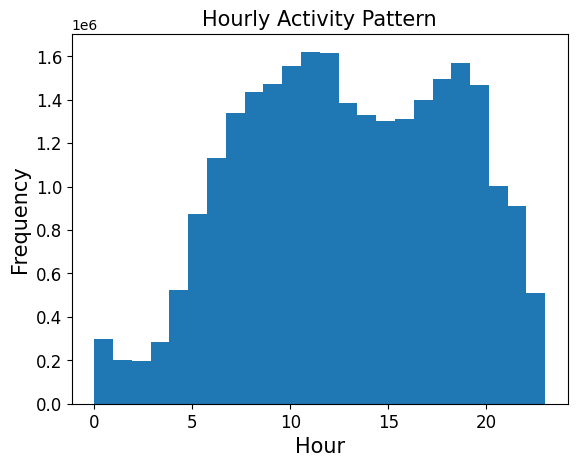

In [ ]:
# Visualize activity patterns
dfs['hour'].hist(bins=24, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Hour", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Hourly Activity Pattern", fontsize=15)

In [ ]:
# Look at session lengths
dfs_grouped = dfs.groupby('session')['ts_conv'].agg([min, max])
dfs_grouped['diff'] = dfs_grouped['max'] - dfs_grouped['min']
dfs_grouped['diff_hours'] = dfs_grouped['diff'].dt.total_seconds() / 3600  # Convert to hours

Text(0, 0.5, 'Counts')

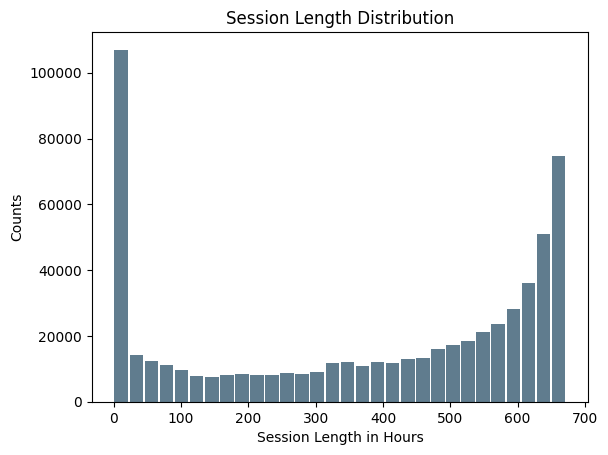

In [ ]:
# Visualize session lengths
dfs_grouped['diff_hours'].hist(grid=False, bins=30, rwidth=0.9, color='#607c8e')
plt.title('Session Length Distribution')
plt.xlabel('Session Length in Hours')
plt.ylabel('Counts')

In [ ]:
idx_0 = dfs_grouped.query('diff.dt.days == 0').index.to_list()
idx_27 = dfs_grouped.query('diff.dt.days == 27').index.to_list()

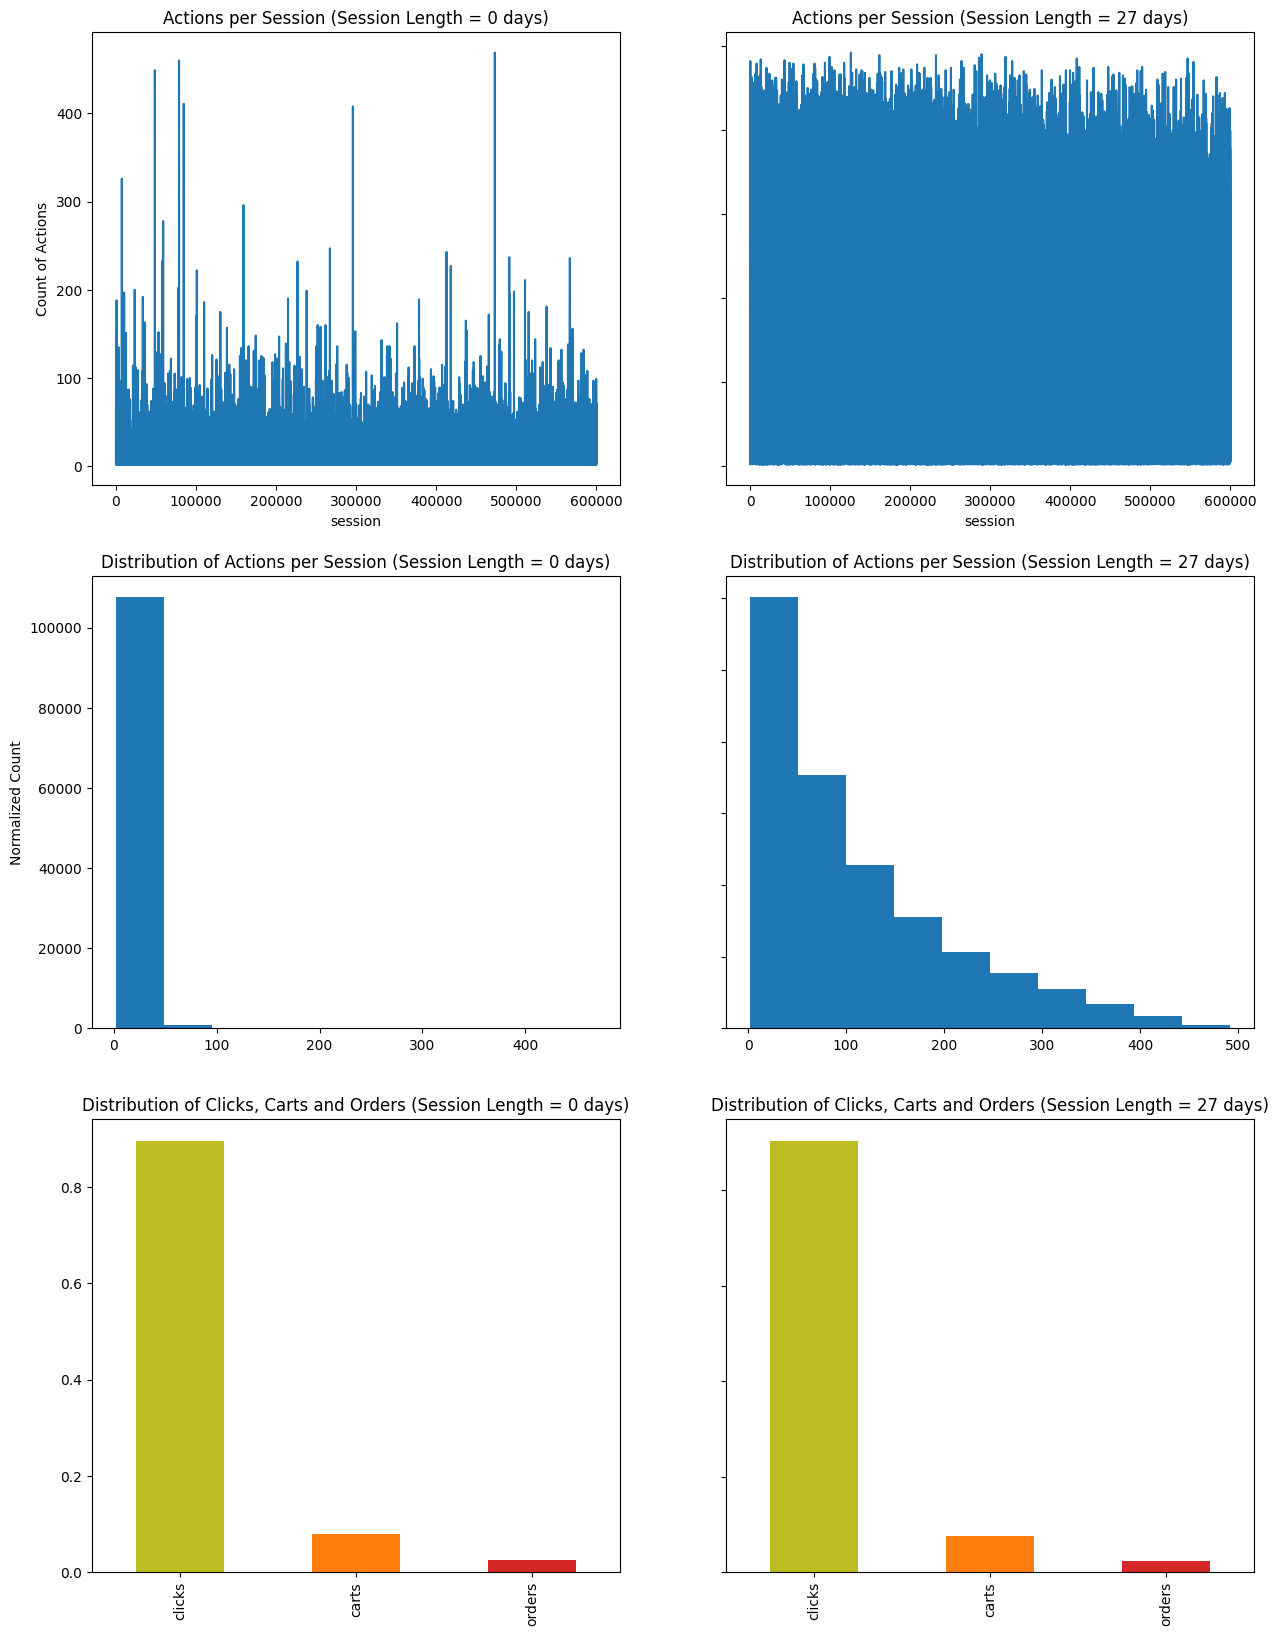

In [ ]:
colors = ['tab:olive', 'tab:orange', 'tab:red']

fig, axs = plt.subplots(3, 2, figsize=(15,20))
dfs.query('session in @idx_0').groupby('session').size().plot.hist(ax=axs[1,0])
dfs.query('session in @idx_0').type.value_counts(normalize=True).plot(kind='bar',ax=axs[2,0], color=colors)
dfs.query('session in @idx_0').groupby('session').size().plot(ax=axs[0,0])
dfs.query('session in @idx_27').type.value_counts(normalize=True).plot(kind='bar',ax=axs[2,1],  color=colors)
dfs.query('session in @idx_27').groupby('session').size().plot(ax=axs[0,1], sharey = axs[0,0])
dfs.query('session in @idx_27').groupby('session').size().plot.hist(ax=axs[1,1])
axs[0,0].set_ylabel('Count of Actions')
axs[1,0].set_ylabel('Normalized Count')
axs[0,0].set_title('Actions per Session (Session Length = 0 days)')
axs[0,1].set_title('Actions per Session (Session Length = 27 days)')
axs[1,0].set_title('Distribution of Actions per Session (Session Length = 0 days)')
axs[1,1].set_title('Distribution of Actions per Session (Session Length = 27 days)')
axs[2,0].set_title('Distribution of Clicks, Carts and Orders (Session Length = 0 days)')
axs[2,1].set_title('Distribution of Clicks, Carts and Orders (Session Length = 27 days)')
plt.show()

> So there is seemingly **no difference in the distributions** of <span style="color:olive"> Clicks</span>, <span style="color:orange">Carts</span>, <span style="color:red">Orders</span> whether the session lasts 27 or 0 days <br>
> However the distribution of <span style="color:blue">Actions</span> shows, that all **sessions lasting shorter than 1 day had less than 50 actions** while for longer session the distribution looks more like a normal distribution

<AxesSubplot:title={'center':'Top 10 Most Clicked Articles'}>

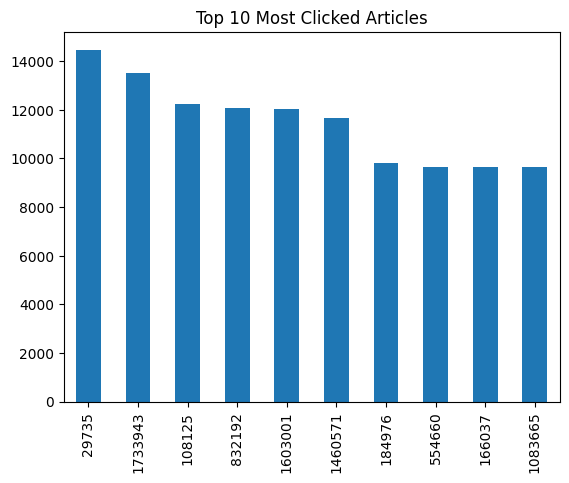

In [ ]:
# Look at the distribution of aids
aid_counts = dfs['aid'].value_counts()
aid_counts[:10].plot(kind='bar', title='Top 10 Most Clicked aids')

In [ ]:
# Analyze conversions
conversions = dfs.groupby('session')['type'].apply(lambda x: 'orders' in x.values).mean()
print(f'Conversion Rate: {conversions * 100:.2f}%')

Conversion Rate: 23.95%


In [ ]:
# Check for sessions with abnormally high activity
sessions_counts = dfs['session'].value_counts()
high_activity_sessions = sessions_counts[sessions_counts > sessions_counts.quantile(0.99)]  # Change threshold as needed
print(f'Sessions with High Activity: {len(high_activity_sessions)}')

Sessions with High Activity: 5959


In [ ]:
# We want to analyze high activity sessions further:
for session_id in high_activity_sessions.index[:10]:  # Change limit as needed
    print(f'Session {session_id}')
    print(dfs[dfs['session'] == session_id]['type'].value_counts())
    print('\n')

Session 352795
clicks    443
carts      40
orders     15
Name: type, dtype: int64


Session 584209
clicks    491
carts       3
orders      3
Name: type, dtype: int64


Session 7905
clicks    472
carts      23
Name: type, dtype: int64


Session 128925
clicks    415
carts      60
orders     19
Name: type, dtype: int64


Session 250979
clicks    467
carts      23
orders      4
Name: type, dtype: int64


Session 280318
clicks    493
Name: type, dtype: int64


Session 29248
clicks    493
Name: type, dtype: int64


Session 94753
clicks    472
carts      15
orders      6
Name: type, dtype: int64


Session 321269
clicks    417
carts      76
Name: type, dtype: int64


Session 125985
clicks    429
carts      60
orders      3
Name: type, dtype: int64




In [ ]:
# Analyze Last action within a Session
dfs['is_last_action'] = dfs.groupby('session')['ts'].transform(max) == dfs['ts']
last_actions = dfs[dfs['is_last_action']]['type'].value_counts()
print('Last Actions:')
print(last_actions)

Last Actions:
clicks    553241
orders     50083
carts      23351
Name: type, dtype: int64


In [ ]:
# Additional imports
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
import seaborn as sns

In [ ]:
!pip install lifelines --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Using cached lifelines-0.27.7-py3-none-any.whl (409 kB)
  Using cached autograd-1.6.2-py3-none-any.whl (49 kB)
  Using cached autograd_gamma-0.5.0-py3-none-any.whl
  Using cached formulaic-0.6.4-py3-none-any.whl (88 kB)
  Using cached future-0.18.3-py3-none-any.whl
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached graphlib_backport-1.0.3-py3-none-any.whl (5.1 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl (14 kB)


Text(0.5, 1.0, 'Action Type Distribution Over Time')

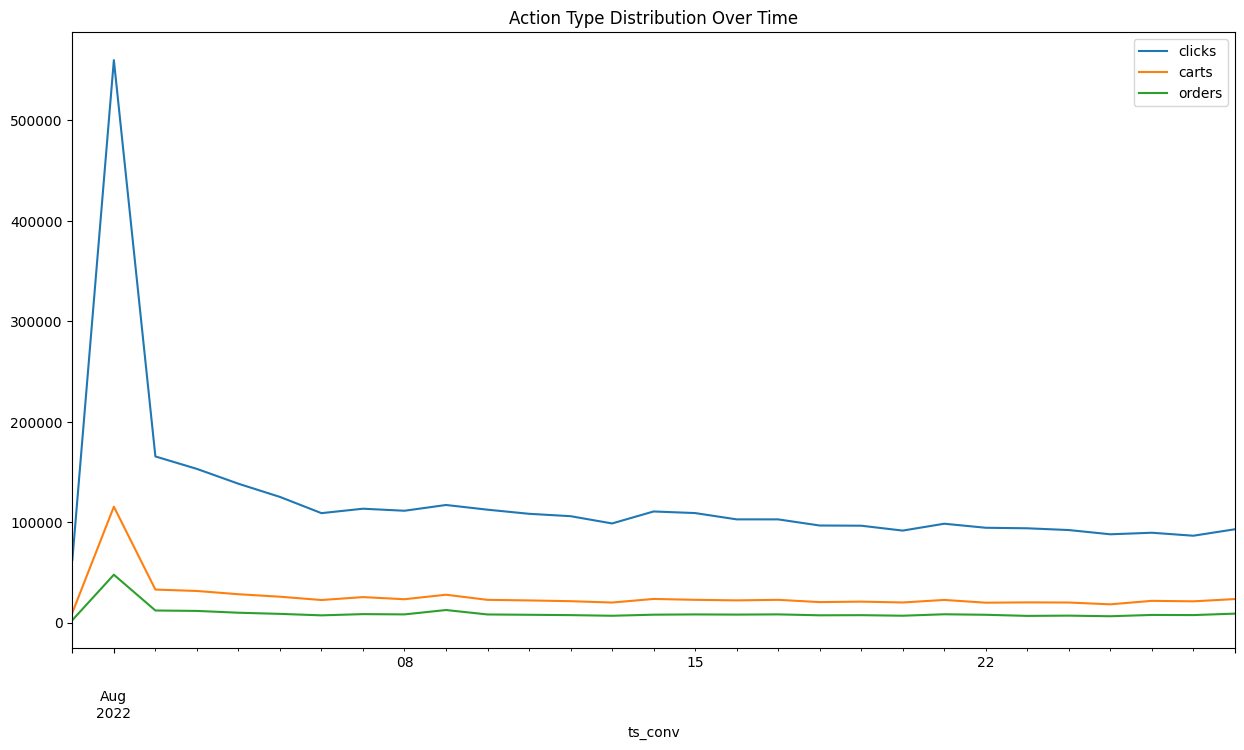

In [ ]:
# Exploring the distribution of each action type across time.
plt.figure(figsize=(15,8))
for action_type in dfs['type'].unique():
    subset = dfs[dfs['type'] == action_type]
    subset.set_index('ts_conv')['session'].resample('D').nunique().plot(label=action_type)
plt.legend()
plt.title('Action Type Distribution Over Time')

Text(0.5, 1.0, 'Survival Analysis of Session Duration')

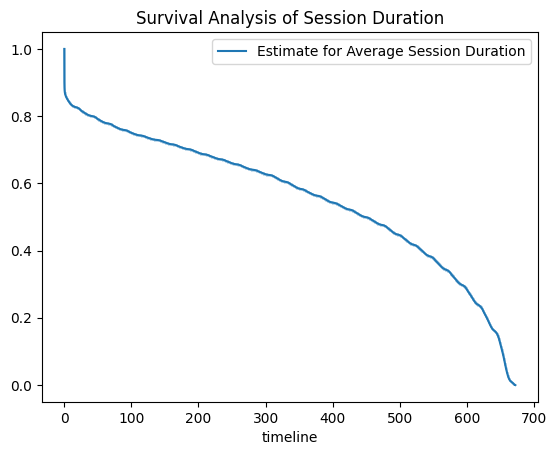

In [ ]:
# Survival analysis to estimate the duration of sessions.
kmf = KaplanMeierFitter()
kmf.fit(dfs_grouped['diff'].dt.total_seconds()/3600, label='Estimate for Average Session Duration')  # convert to hours
kmf.plot()
plt.title('Survival Analysis of Session Duration')